In [85]:
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

import imblearn as imb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler, InstanceHardnessThreshold, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.keras import BalancedBatchGenerator
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from mpl_toolkits.mplot3d import Axes3D
import ast

from keras.models import Sequential # type: ignore
from keras.layers import Dense, Dropout, BatchNormalization # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy # type: ignore
from keras.metrics import Accuracy, AUC # type: ignore
from keras.callbacks import EarlyStopping # type: ignore



## Erythromycin

In [75]:
df = pd.read_csv('../data/practica_micro.csv')

# Create a new DataFrame with 6000 columns from the 'MALDI_binned' column
df['MALDI_binned'] = df['MALDI_binned'].apply(ast.literal_eval)
maldi_binned_df = pd.DataFrame(df['MALDI_binned'].tolist(), index=df.index)
df_expanded = pd.concat([maldi_binned_df, df.drop(columns=['MALDI_binned'])], axis=1)
df_expanded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5962,5963,5964,5965,5966,5967,5968,5969,5970,5971,5972,5973,5974,5975,5976,5977,5978,5979,5980,5981,5982,5983,5984,5985,5986,5987,5988,5989,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999,Erythromycin,Ciprofloxacin
0,0.000254,0.000395,0.000453,0.000495,0.000801,0.000879,0.001296,0.000631,0.000040,0.000295,0.000369,0.001278,0.001768,0.000413,0.000317,0.000162,0.000188,0.000629,0.000108,0.000398,0.000786,0.000790,0.004846,0.004197,0.001235,0.000907,0.000749,0.001577,0.001408,0.000702,0.000908,0.000474,0.000434,0.000215,0.001087,0.003671,0.002406,0.000327,0.000323,0.000452,...,0.000018,0.000004,0.000003,0.000047,0.000058,0.000071,0.000082,0.000106,0.000069,0.000067,0.000064,0.000075,0.000017,0.000008,0.000009,0.000014,0.000029,0.000032,0.000063,1.204154e-04,0.000072,0.000068,0.000068,0.000093,0.000064,0.000031,0.000006,0.000004,3.847418e-07,0.000005,0.000023,0.000062,0.000061,0.000056,0.000071,0.000052,0.000044,0.000025,0.0,0.0
1,0.000339,0.000203,0.000097,0.000844,0.000769,0.000667,0.000974,0.000557,0.000116,0.000038,0.000812,0.001888,0.001096,0.000343,0.000144,0.000022,0.000265,0.000268,0.000160,0.000407,0.000471,0.002459,0.004366,0.002007,0.000521,0.000150,0.001120,0.001391,0.001676,0.002199,0.000736,0.000178,0.000099,0.000134,0.001681,0.002782,0.001076,0.000131,0.000127,0.000400,...,0.000068,0.000066,0.000102,0.000060,0.000068,0.000080,0.000119,0.000058,0.000047,0.000035,0.000026,0.000002,0.000007,0.000028,0.000051,0.000028,0.000029,0.000038,0.000073,5.727302e-05,0.000065,0.000098,0.000056,0.000043,0.000038,0.000070,0.000064,0.000065,6.344351e-05,0.000070,0.000056,0.000074,0.000096,0.000154,0.000075,0.000067,0.000042,0.000022,0.0,0.0
2,0.000123,0.000162,0.000089,0.000671,0.000563,0.001250,0.001091,0.000240,0.000078,0.000060,0.000769,0.002504,0.001477,0.000710,0.000193,0.000243,0.000706,0.000217,0.000127,0.000603,0.000318,0.003928,0.006222,0.002374,0.000975,0.000538,0.001292,0.001395,0.000501,0.000927,0.000968,0.000356,0.000093,0.000575,0.003753,0.003459,0.001051,0.000158,0.000252,0.000185,...,0.000031,0.000056,0.000035,0.000046,0.000062,0.000091,0.000058,0.000073,0.000079,0.000124,0.000080,0.000065,0.000045,0.000032,0.000008,0.000023,0.000031,0.000047,0.000057,6.375351e-05,0.000049,0.000055,0.000049,0.000057,0.000064,0.000085,0.000033,0.000030,1.657958e-05,0.000006,0.000029,0.000055,0.000112,0.000084,0.000072,0.000060,0.000046,0.000003,1.0,0.0
3,0.000282,0.000608,0.000158,0.000486,0.000495,0.000468,0.000414,0.000147,0.000160,0.000277,0.000366,0.000747,0.000689,0.000531,0.000115,0.000133,0.000317,0.000317,0.000241,0.000120,0.000077,0.001126,0.001816,0.000597,0.000297,0.000636,0.001470,0.001298,0.000755,0.000763,0.000270,0.000061,0.000407,0.000442,0.001028,0.001111,0.000261,0.000239,0.000815,0.000772,...,0.000004,0.000014,0.000023,0.000018,0.000031,0.000036,0.000048,0.000033,0.000032,0.000033,0.000052,0.000026,0.000026,0.000025,0.000024,0.000016,0.000020,0.000021,0.000037,2.242340e-05,0.000026,0.000059,0.000041,0.000048,0.000056,0.000098,0.000064,0.000056,4.959213e-05,0.000073,0.000037,0.000015,0.000003,0.000004,0.000021,0.000036,0.000045,0.000096,0.0,1.0
4,0.000370,0.000243,0.000149,0.000620,0.000307,0.000999,0.000981,0.000304,0.000262,0.000104,0.000542,0.002032,0.001384,0.000076,0.000295,0.000353,0.000877,0.000701,0.000196,0.000414,0.000661,0.002510,0.005224,0.002529,0.000431,0.000257,0.001152,0.002327,0.001669,0.000877,0.001042,0.000806,0.000299,0.000142,0.001883,0.003137,0.001184,0.000228,0.000027,0.000151,...,0.000021,0.000037,0.000058,0.000039,0.000041,0.000043,0.000057,0.000047,0.000042,0.000052,0.000087,0.000073,0.000086,0.000084,0.000122,0.000065,0.000050,0.000040,0.000022,5.832555e-07,0.000007,0.000014,0.000031,0.000028,0.000041,0.000086,0.000053,0.000058,6.183159e-05,0.000086,0.000050,0.000037,0.000025,0.000051,0.000056,0.000078,0.000099,0.000140,0.0,0.0


In [76]:
# Definir conjuntos x e y
X = df_expanded.drop(columns=['Erythromycin', 'Ciprofloxacin'])
y = df_expanded['Erythromycin']

X_train = X.sample(frac=0.8, replace=False)
X_test = X.drop(X_train.index)
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=73, stratify=y_train)

# Tamaños de los datasets resultantes
print("X_train shape:", X_train.shape)
#print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
#print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1385, 6000)
X_test shape: (346, 6000)
y_train shape: (1385,)
y_test shape: (346,)


## Ciprofloxacin

In [86]:
df = pd.read_csv('../data/practica_micro.csv')

# Create a new DataFrame with 6000 columns from the 'MALDI_binned' column
df['MALDI_binned'] = df['MALDI_binned'].apply(ast.literal_eval)
maldi_binned_df = pd.DataFrame(df['MALDI_binned'].tolist(), index=df.index)
df_expanded = pd.concat([maldi_binned_df, df.drop(columns=['MALDI_binned'])], axis=1)
df_expanded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5962,5963,5964,5965,5966,5967,5968,5969,5970,5971,5972,5973,5974,5975,5976,5977,5978,5979,5980,5981,5982,5983,5984,5985,5986,5987,5988,5989,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999,Erythromycin,Ciprofloxacin
0,0.000254,0.000395,0.000453,0.000495,0.000801,0.000879,0.001296,0.000631,0.000040,0.000295,0.000369,0.001278,0.001768,0.000413,0.000317,0.000162,0.000188,0.000629,0.000108,0.000398,0.000786,0.000790,0.004846,0.004197,0.001235,0.000907,0.000749,0.001577,0.001408,0.000702,0.000908,0.000474,0.000434,0.000215,0.001087,0.003671,0.002406,0.000327,0.000323,0.000452,...,0.000018,0.000004,0.000003,0.000047,0.000058,0.000071,0.000082,0.000106,0.000069,0.000067,0.000064,0.000075,0.000017,0.000008,0.000009,0.000014,0.000029,0.000032,0.000063,1.204154e-04,0.000072,0.000068,0.000068,0.000093,0.000064,0.000031,0.000006,0.000004,3.847418e-07,0.000005,0.000023,0.000062,0.000061,0.000056,0.000071,0.000052,0.000044,0.000025,0.0,0.0
1,0.000339,0.000203,0.000097,0.000844,0.000769,0.000667,0.000974,0.000557,0.000116,0.000038,0.000812,0.001888,0.001096,0.000343,0.000144,0.000022,0.000265,0.000268,0.000160,0.000407,0.000471,0.002459,0.004366,0.002007,0.000521,0.000150,0.001120,0.001391,0.001676,0.002199,0.000736,0.000178,0.000099,0.000134,0.001681,0.002782,0.001076,0.000131,0.000127,0.000400,...,0.000068,0.000066,0.000102,0.000060,0.000068,0.000080,0.000119,0.000058,0.000047,0.000035,0.000026,0.000002,0.000007,0.000028,0.000051,0.000028,0.000029,0.000038,0.000073,5.727302e-05,0.000065,0.000098,0.000056,0.000043,0.000038,0.000070,0.000064,0.000065,6.344351e-05,0.000070,0.000056,0.000074,0.000096,0.000154,0.000075,0.000067,0.000042,0.000022,0.0,0.0
2,0.000123,0.000162,0.000089,0.000671,0.000563,0.001250,0.001091,0.000240,0.000078,0.000060,0.000769,0.002504,0.001477,0.000710,0.000193,0.000243,0.000706,0.000217,0.000127,0.000603,0.000318,0.003928,0.006222,0.002374,0.000975,0.000538,0.001292,0.001395,0.000501,0.000927,0.000968,0.000356,0.000093,0.000575,0.003753,0.003459,0.001051,0.000158,0.000252,0.000185,...,0.000031,0.000056,0.000035,0.000046,0.000062,0.000091,0.000058,0.000073,0.000079,0.000124,0.000080,0.000065,0.000045,0.000032,0.000008,0.000023,0.000031,0.000047,0.000057,6.375351e-05,0.000049,0.000055,0.000049,0.000057,0.000064,0.000085,0.000033,0.000030,1.657958e-05,0.000006,0.000029,0.000055,0.000112,0.000084,0.000072,0.000060,0.000046,0.000003,1.0,0.0
3,0.000282,0.000608,0.000158,0.000486,0.000495,0.000468,0.000414,0.000147,0.000160,0.000277,0.000366,0.000747,0.000689,0.000531,0.000115,0.000133,0.000317,0.000317,0.000241,0.000120,0.000077,0.001126,0.001816,0.000597,0.000297,0.000636,0.001470,0.001298,0.000755,0.000763,0.000270,0.000061,0.000407,0.000442,0.001028,0.001111,0.000261,0.000239,0.000815,0.000772,...,0.000004,0.000014,0.000023,0.000018,0.000031,0.000036,0.000048,0.000033,0.000032,0.000033,0.000052,0.000026,0.000026,0.000025,0.000024,0.000016,0.000020,0.000021,0.000037,2.242340e-05,0.000026,0.000059,0.000041,0.000048,0.000056,0.000098,0.000064,0.000056,4.959213e-05,0.000073,0.000037,0.000015,0.000003,0.000004,0.000021,0.000036,0.000045,0.000096,0.0,1.0
4,0.000370,0.000243,0.000149,0.000620,0.000307,0.000999,0.000981,0.000304,0.000262,0.000104,0.000542,0.002032,0.001384,0.000076,0.000295,0.000353,0.000877,0.000701,0.000196,0.000414,0.000661,0.002510,0.005224,0.002529,0.000431,0.000257,0.001152,0.002327,0.001669,0.000877,0.001042,0.000806,0.000299,0.000142,0.001883,0.003137,0.001184,0.000228,0.000027,0.000151,...,0.000021,0.000037,0.000058,0.000039,0.000041,0.000043,0.000057,0.000047,0.000042,0.000052,0.000087,0.000073,0.000086,0.000084,0.000122,0.000065,0.000050,0.000040,0.000022,5.832555e-07,0.000007,0.000014,0.000031,0.000028,0.000041,0.000086,0.000053,0.000058,6.183159e-05,0.000086,0.000050,0.000037,0.000025,0.000051,0.000056,0.000078,0.000099,0.000140,0.0,0.0


In [87]:
# Definir conjuntos x e y
X = df_expanded.drop(columns=['Erythromycin', 'Ciprofloxacin'])
y = df_expanded['Ciprofloxacin']

X_train = X.sample(frac=0.8, replace=False)
X_test = X.drop(X_train.index)
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=73, stratify=y_train)

# Tamaños de los datasets resultantes
print("X_train shape:", X_train.shape)
#print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
#print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1385, 6000)
X_test shape: (346, 6000)
y_train shape: (1385,)
y_test shape: (346,)


## Keras NN

### With Validation Set to check number of epochs and avoid overfitting

Epoch 1/50


c:\Users\guigr\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\guigr\anaconda3\envs\tfm\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc_13: 0.5253 - loss: 0.5913 - val_auc_13: 0.5008 - val_loss: 0.1573
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc_13: 0.6826 - loss: 0.3067 - val_auc_13: 0.4984 - val_loss: 0.2397
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc_13: 0.7665 - loss: 0.2307 - val_auc_13: 0.4865 - val_loss: 0.2518
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc_13: 0.8351 - loss: 0.1839 - val_auc_13: 0.5188 - val_loss: 0.7926
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc_13: 0.9116 - loss: 0.1164 - val_auc_13: 0.5354 - val_loss: 0.3555
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc_13: 0.9199 - loss: 0.1047 - val_auc_13: 0.5471 - val_loss: 0.3078


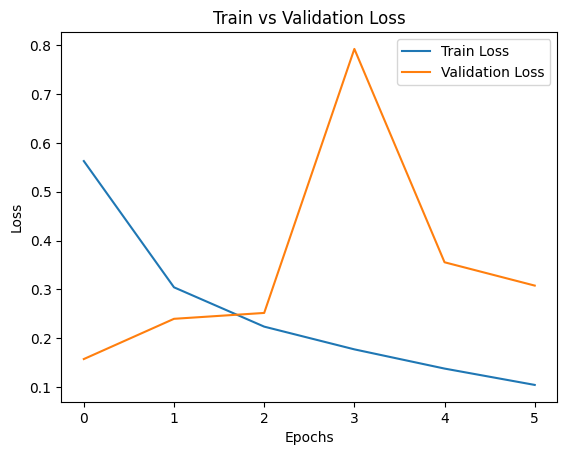

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Balanced Accuracy: 0.503887545631252


In [ ]:
### USANDO VALIDACIÓN ###

# Crear el pipeline con MinMaxScaler y PCA
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', KernelPCA(n_components=1000))  # Retener el 95% de la varianza
])

# Ajustar el pipeline en el conjunto de entrenamiento y transformar los datos
X_train_scaled = pipeline.fit_transform(X_train)
# Aplicar la misma transformación al conjunto de valid y test
X_val_scaled = pipeline.transform(X_val)
X_test_scaled = pipeline.transform(X_test)

training_generator = BalancedBatchGenerator(
    X_train_scaled, y_train, sampler=RandomUnderSampler(), batch_size=32, random_state=73
)

model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Prueba también tanh
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryFocalCrossentropy(), metrics=[AUC()])

# Early stopping para prevenir overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    training_generator,
    epochs=50,  # Puedes aumentar las épocas para observar mejor el overfitting
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Graficar pérdidas para detectar overfitting
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()

# Predecir en test
y_pred = model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
print(f"Balanced Accuracy: {balanced_accuracy}")

### Without Validation Set since there is very few data

In [ ]:
# Crear el pipeline con MinMaxScaler y PCA
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=324))  # Retener el 65% de la varianza
    ('smotetomek', SMOTETomek(random_state=73, sampling_strategy=1.))
])

# Ajustar el pipeline en el conjunto de entrenamiento y transformar los datos
X_train_scaled = pipeline.fit_transform(X_train)
# Aplicar la misma transformación al conjunto de test
X_test_scaled = pipeline.transform(X_test)

training_generator = BalancedBatchGenerator(
    X_train_scaled, y_train, sampler=RandomUnderSampler(), batch_size=32, random_state=73
)

model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Prueba también tanh
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryFocalCrossentropy(), metrics=[AUC()])



# Entrenar el modelo
history = model.fit(
    training_generator,
    epochs=10,  # Puedes aumentar las épocas para observar mejor el overfitting
    verbose=1
)

# Predecir en test
y_pred = model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
print(f"Balanced Accuracy: {balanced_accuracy}")

Epoch 1/10


c:\Users\guigr\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\guigr\anaconda3\envs\tfm\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc_17: 0.5118 - loss: 0.5739
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_17: 0.6377 - loss: 0.3555 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_17: 0.7034 - loss: 0.2681 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_17: 0.7964 - loss: 0.1832 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_17: 0.8003 - loss: 0.1849 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_17: 0.8304 - loss: 0.1660 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_17: 0.8900 - loss: 0.1241 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_17: 0.8988 - loss: 0.1237 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_17: 0.9179 - loss: 0.1180 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_17: 0.9557 - loss: 0.0761 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Balanced Accuracy: 0.5619483229016209


### Explainability with SHAP

In [ ]:
import shap

# Apply SHAP to MALDI-TOF Data
explainer_shap_pca = shap.Explainer(model, X_test_scaled)
shap_values_pca = explainer_shap_pca(X_test_scaled, max_evals=2001)
print(shap_values_pca.shape)

### Convert SHAP values from PCA space back to original feature space

# Get PCA from the pipeline
pca = pipeline.named_steps['pca']

# Convert SHAP values from PCA space back to original feature space
shap_values_original = np.dot(shap_values_pca.values, pca.components_)  # Inverse transform

# Generate feature names for the selected features
selected_feature_names = "Bin " + pd.Series(range(0, 6000)).astype(str)

# Specify the class index you want to explain
class_index = 0
shap_values_class_0 = shap_values_original[:, :, class_index]  # Convert for class 0
shap.summary_plot(shap_values_class_0, X_test_scaled, feature_names=selected_feature_names, plot_type="bar")

# Specify the class index you want to explain
class_index = 1
shap_values_class_1 = shap_values_original[:, :, class_index]  # Convert for class 1
shap.summary_plot(shap_values_class_1, X_test_scaled, feature_names=selected_feature_names, plot_type="bar")

PermutationExplainer explainer: 347it [03:47,  1.46it/s]                         

(346, 500)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

## Random Forest

In [ ]:
# Apply MinMaxScaler
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Lasso for feature selection
lasso = LassoCV(cv=5, random_state=73)
lasso.fit(X_train_scaled, y_train)

# # Select features with non-zero coefficients
selected_features = np.where(lasso.coef_ != 0)[0]
X_train_scaled = X_train_scaled[:, selected_features]
X_test_scaled = X_test_scaled[:, selected_features]

# Apply SMOTETomek for resampling
smote_tomek = SMOTETomek(random_state=73, sampling_strategy=1.)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}

# Initialize the RandomForestClassifier
rf_classifier = BalancedRandomForestClassifier(random_state=73)

# Initialize GridSearchCV with the RandomForestClassifier and the parameter grid
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Fit the RandomForestClassifier with the best parameters on the training data
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_rf = best_rf_classifier.predict(X_test_scaled)

# Calculate balanced accuracy
balanced_accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf)
print(f"Balanced Accuracy (Random Forest): {balanced_accuracy_rf}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_depth': 20, 'n_estimators': 200}
Best cross-validation score: 0.716438750343279
Balanced Accuracy (Random Forest): 0.6617494824016563


Más pruebas

In [ ]:
# Apply MinMaxScaler
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Apply StandardScaler
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

# Apply Lasso for feature selection
# lasso = LassoCV(cv=5, random_state=73)
# lasso.fit(X_train_scaled, y_train)
# # Select features with non-zero coefficients
# selected_features = np.where(lasso.coef_ != 0)[0]
# X_train_scaled = X_train_scaled[:, selected_features]
# X_test_scaled = X_test_scaled[:, selected_features]

# Apply PCA
pca = PCA(n_components=324)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

# # Apply RandomUnderSampler
# under_sampler = RandomUnderSampler(random_state=73)
# X_train_under, y_train_under = under_sampler.fit_resample(X_train_scaled, y_train)

# # # # Apply SMOTE
# smote = SMOTE(random_state=73)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_under, y_train_under)

# Apply SMOTETomek for resampling
smote_tomek = SMOTETomek(random_state=73, sampling_strategy=1.)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=73, max_depth=20, n_estimators=50)

rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Calculate balanced accuracy
balanced_accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf)
print(f"Balanced Accuracy (Random Forest): {balanced_accuracy_rf}")


Balanced Accuracy (Random Forest): 0.5326897018970189


In [18]:
# Create a SHAP explainer for the Random Forest model
explainer_rf = shap.Explainer(best_rf_classifier, X_test_scaled)

# Compute SHAP values for the test set
shap_values_rf = explainer_rf(X_test_scaled)

print(shap_values_rf.shape)

(346, 63, 2)


In [ ]:
# Generate feature names for the selected features
selected_feature_names = [f"Feature_{i+1}" for i in selected_features]

# Specify the class index you want to explain
class_index = 1
shap_values_class_1 = shap_values_rf[:, :, class_index]
# Generate a summary plot to visualize the SHAP values
shap.summary_plot(shap_values_class_1, X_test_scaled, feature_names=selected_feature_names)

In [35]:
# Renombrar las columnas del DataFrame maldi_binned_df
new_column_names = [f"Feature {2000 + i*3}-{2002 + i*3} Da" for i in range(maldi_binned_df.shape[1])]
maldi_binned_df.columns = new_column_names

# Mostrar las primeras filas del DataFrame con los nuevos nombres de columnas
maldi_binned_df.head()

,Feature 2000-2002 Da,Feature 2003-2005 Da,Feature 2006-2008 Da,Feature 2009-2011 Da,Feature 2012-2014 Da,Feature 2015-2017 Da,Feature 2018-2020 Da,Feature 2021-2023 Da,Feature 2024-2026 Da,Feature 2027-2029 Da,...,Feature 19970-19972 Da,Feature 19973-19975 Da,Feature 19976-19978 Da,Feature 19979-19981 Da,Feature 19982-19984 Da,Feature 19985-19987 Da,Feature 19988-19990 Da,Feature 19991-19993 Da,Feature 19994-19996 Da,Feature 19997-19999 Da
0,0.000254,0.000395,0.000453,0.000495,0.000801,0.000879,0.001296,0.000631,0.000040,0.000295,...,3.847418e-07,0.000005,0.000023,0.000062,0.000061,0.000056,0.000071,0.000052,0.000044,0.000025
1,0.000339,0.000203,0.000097,0.000844,0.000769,0.000667,0.000974,0.000557,0.000116,0.000038,...,6.344351e-05,0.000070,0.000056,0.000074,0.000096,0.000154,0.000075,0.000067,0.000042,0.000022
2,0.000123,0.000162,0.000089,0.000671,0.000563,0.001250,0.001091,0.000240,0.000078,0.000060,...,1.657958e-05,0.000006,0.000029,0.000055,0.000112,0.000084,0.000072,0.000060,0.000046,0.000003
3,0.000282,0.000608,0.000158,0.000486,0.000495,0.000468,0.000414,0.000147,0.000160,0.000277,...,4.959213e-05,0.000073,0.000037,0.000015,0.000003,0.000004,0.000021,0.000036,0.000045,0.000096
4,0.000370,0.000243,0.000149,0.000620,0.000307,0.000999,0.000981,0.000304,0.000262,0.000104,...,6.183159e-05,0.000086,0.000050,0.000037,0.000025,0.000051,0.000056,0.000078,0.000099,0.000140


In [ ]:
# Generate feature names for the selected features using new_column_names
selected_feature_names_new = [new_column_names[i] for i in selected_features]

# Specify the class index you want to explain
class_index = 0
shap_values_class_0 = shap_values_rf[:, :, class_index]
# Generate a summary plot to visualize the SHAP values
shap.summary_plot(shap_values_class_0, X_test_scaled, feature_names=selected_feature_names_new, plot_type="bar")

# Specify the class index you want to explain
class_index = 1
shap_values_class_1 = shap_values_rf[:, :, class_index]
# Generate a summary plot to visualize the SHAP values
shap.summary_plot(shap_values_class_1, X_test_scaled, feature_names=selected_feature_names_new, plot_type="bar")

## Balanced Random Forest Classifier

In [88]:
# Apply MinMaxScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Lasso for feature selection
lasso = LassoCV(cv=5, random_state=73)
lasso.fit(X_train_scaled, y_train)

# Select features with non-zero coefficients
selected_features = np.where(lasso.coef_ != 0)[0]
X_train_scaled = X_train_scaled[:, selected_features]
X_test_scaled = X_test_scaled[:, selected_features]

# Apply SMOTETomek for resampling
# smote_tomek = SMOTETomek(random_state=73, sampling_strategy=1.)
# X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}

# Initialize the RandomForestClassifier
rf_classifier = BalancedRandomForestClassifier(random_state=73)

# Initialize GridSearchCV with the RandomForestClassifier and the parameter grid
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Fit the RandomForestClassifier with the best parameters on the training data
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_rf = best_rf_classifier.predict(X_test_scaled)

# Calculate balanced accuracy
balanced_accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf)
print(f"Balanced Accuracy (Random Forest): {balanced_accuracy_rf}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_depth': 10, 'n_estimators': 200}
Best cross-validation score: 0.7538863276642426
Balanced Accuracy (Random Forest): 0.5067600193143409


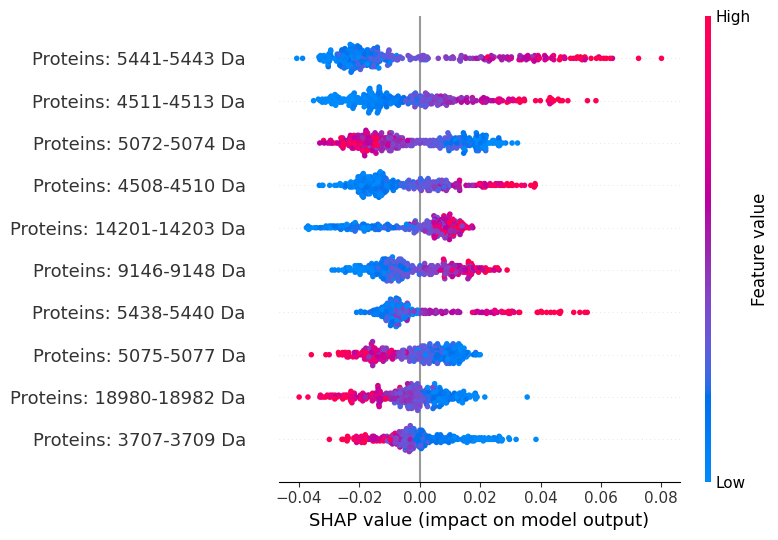

In [83]:
import shap

# Create a SHAP explainer for the Random Forest model
explainer_rf = shap.TreeExplainer(best_rf_classifier)

# Compute SHAP values for the test set
shap_values_rf = explainer_rf(X_test_scaled)

# Generate feature names for the selected features using new_column_names
new_column_names = [f"Proteins: {2000 + i*3}-{2002 + i*3} Da" for i in range(maldi_binned_df.shape[1])]
selected_feature_names_new = [new_column_names[i] for i in selected_features]

# Specify the class index you want to explain
class_index = 1
shap_values_class_1 = shap_values_rf[:, :, class_index]
# Generate a summary plot to visualize the SHAP values
shap.summary_plot(shap_values_class_1, X_test_scaled, feature_names=selected_feature_names_new, max_display=10)

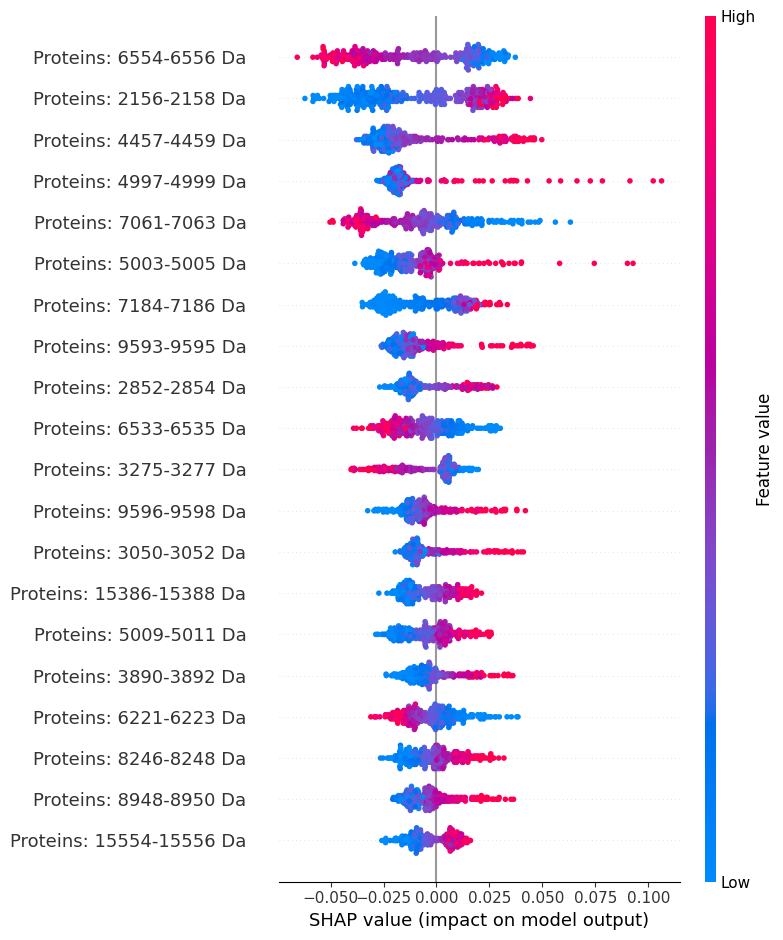

In [90]:
import shap

# Create a SHAP explainer for the Random Forest model
explainer_rf = shap.TreeExplainer(best_rf_classifier)

# Compute SHAP values for the test set
shap_values_rf = explainer_rf(X_test_scaled)

# Generate feature names for the selected features using new_column_names
new_column_names = [f"Proteins: {2000 + i*3}-{2002 + i*3} Da" for i in range(maldi_binned_df.shape[1])]
selected_feature_names_new = [new_column_names[i] for i in selected_features]

# Specify the class index you want to explain
class_index = 1
shap_values_class_1 = shap_values_rf[:, :, class_index]
# Generate a summary plot to visualize the SHAP values
shap.summary_plot(shap_values_class_1, X_test_scaled, feature_names=selected_feature_names_new)